# Hack My Ride
## Exploratory Data Analysis

* * *

The purpose of this notebook is to get a first sneak into the datasets provided, how it is structured, and get an understanding into how we are going to deal with the data as well as some initial analysis.

In [1]:
import pandas as pd
import geopandas as gpd
import json
import gtfs_kit as gk
from pathlib import Path
import warnings
import numpy as np
from datetime import datetime
import datetime as dt
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score
warnings.filterwarnings('ignore')
%matplotlib inline
from hmr_utils import *


In [2]:
data_folder = '/Users/alfredo.leon/Desktop/DataMiningProject/Project Data-20221021/'

### CSV Files
#### Agency

In [3]:
agency = pd.read_csv(data_folder + "gtfs3Sept/agency.txt", index_col=None)
agency.head()

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone
0,STIB-MIVB,STIB,http://www.stib-mivb.be,Europe/Brussels,fr,070 23 2000


Only one row.

#### Calendar Dates

In [ ]:
calendar_dates = pd.read_csv(data_folder + "gtfs3Sept/calendar_dates.txt", index_col='service_id')
print(calendar_dates.shape)
calendar_dates.sort_values(by="service_id").head()

This table relates services with dates.
#### Calendar

In [ ]:
calendar = pd.read_csv(data_folder + "gtfs3Sept/calendar.txt", index_col=None)
calendar.loc[calendar['service_id'] == 233898050]

Apparently this table gives a more detailed description of the schedule of a particular service.
#### Routes

In [ ]:
routes = pd.read_csv(data_folder + "gtfs3Sept/routes.txt", index_col='route_id')
routes.head()

In [ ]:
routes.loc[routes['route_short_name'] == '71']

This table describes the routes, provides an id for each route. Note that the route identifier differs from the route short name.
#### Shapes

In [ ]:
shapes = pd.read_csv(data_folder + "gtfs3Sept/shapes.txt", index_col=None)
shapes.head()

I guess this csv is to be able to put the shapes on a specific latitude and longitude.
#### Stop Times

In [ ]:
stop_times = pd.read_csv(data_folder + "gtfs3Sept/stop_times.txt", index_col=None)
print(stop_times.shape)
stop_times.head()

This table records the trip stop times.
#### Stops

In [4]:
stops = pd.read_csv(data_folder + "gtfs3Sept/stops.txt", index_col=None)
print(stops.shape)
stops.loc[stops['stop_id']=='4014']

(2998, 10)


,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
1653,4014,NaN,BEEKKANT,NaN,50.854237,4.323407,NaN,NaN,0,NaN


This table gives more details on a certain stop. Provides latitud and longitude.
#### Translations

In [ ]:
translations = pd.read_csv(data_folder + "gtfs3Sept/translations.txt", index_col=None)
translations.head()

Apparently this kind of table is used to handle all the different languages used in the STIB.
#### Trips

In [ ]:
trips = pd.read_csv(data_folder + "gtfs3Sept/trips.txt", index_col=None)
print(trips.shape)
trips.loc[trips['route_id']==65]

This table matches services, routes, trips and shapes.

In [ ]:
path = Path(data_folder+"gtfs3Sept.zip")
feed = (gk.read_feed(path, dist_units='km'))
feed.validate()

In [ ]:
feed.map_stops(feed.stops.stop_id[:])

In [ ]:
get_route_id_from_route_short_name('95', feed.routes)

In [ ]:
feed.map_routes(['65', '34', '55', '77'], include_stops=True)

In [ ]:
feed.map_trips(trip_ids=['113496397238249601'])

### Understanding the JSONs

In [ ]:
with open(data_folder+"vehiclePosition08.json", "r") as f:
    vehicle8 = json.load(f)

```
{      "lineId": "71",      "vehiclePositions": [        {          "directionId": "3520",          "distanceFromPoint": 395,          "pointId": "2397"        },        {          "directionId": "2596",          "distanceFromPoint": 0,          "pointId": "3521"        },        {          "directionId": "3520",          "distanceFromPoint": 54,          "pointId": "2296"        },        {          "directionId": "2596",          "distanceFromPoint": 66,          "pointId": "5612"        },        {          "directionId": "3520",          "distanceFromPoint": 0,          "pointId": "2596"        },        {          "directionId": "3520",          "distanceFromPoint": 0,          "pointId": "5611"        },        {          "directionId": "3520",          "distanceFromPoint": 185,          "pointId": "3510"        },        {          "directionId": "3520",          "distanceFromPoint": 298,          "pointId": "1597"        },        {          "directionId": "3520",          "distanceFromPoint": 38,          "pointId": "3503"        },        {          "directionId": "2596",          "distanceFromPoint": 34,          "pointId": "3556"        },        {          "directionId": "2596",          "distanceFromPoint": 34,          "pointId": "2963"        }      ]    },    {      "lineId": "72",      "vehiclePositions": [        {          "directionId": "5407",          "distanceFromPoint": 0,          "pointId": "3522"        }      ]    }
```

Using route 71 (Id 65) as an example, we can find that in the jsons it is treated as "lineId". Let's analyse some of the directionIds reported here.

In [ ]:
feed.stops[stops['stop_id'].isin(['3520', '2596'])]

Ok, apparently on the jsons, lineId will refer to the route_short_name attribute in the routes table, instead it should refer to route_id. So data map ends like this:
- lineId = routes.route_short_name
- directionId = stops.stop_id (Terminal stop)
- pointId = stops.stop_id (Last visited stop)
- distanceFromPoint = Distance in meters between bus and pointId (Last visited stop)

Next steps? Brainstorm ideas for project (since it's open ended):
- Select routes that bring students to ULB or close (95, 71, etc).
- Extract their recorded data from jsons.
- Generate maps across timestamps to see evolution of routes. Per timestamps calculate route stats.
- Cluster conflictive stops at particular times.
- Select ideas to improve service.

### Using the parsed jsons in csv format
Please use the other notebook to generate the csvs from the jsons.

In [ ]:
csvs_folder = '/Users/alfredo.leon/Desktop/DataMiningProject/Project Data-20221021/csvs/'

def retrieve_route_data_at_stops_from_csv(route_short_name, input_file, distance_from_point=20.0, 
                                          feed: gk.feed.Feed=None):
    stops = feed.stops.copy(deep=True)
    stops['stop_id'] = stops['stop_id'].astype(str)
    dtypes = {'timestamp': str, 'lineID': np.int64, 'directionID':np.int64, 'pointID': np.int64,
              'distancefromPoint': np.float64, 'time': str, 'year':int, 'month':int, 'day':int, 'hour':int, 'minute':int, 'second':int}
    vehicle_position = pd.read_csv(input_file)
    vehicle_position.dropna(inplace=True)
    for col, dtype in dtypes.items():
        vehicle_position[col] = vehicle_position[col].astype(dtype)
    vehicle_position: pd.DataFrame = vehicle_position.loc[
        (vehicle_position['lineID']==route_short_name) & 
        (vehicle_position['distancefromPoint'] <= distance_from_point)
    ]
    vehicle_position['time'] =  pd.to_datetime(vehicle_position['time'])
    vehicle_position['pointID'] = vehicle_position['pointID'].astype(str)
    vehicle_position.rename(columns={'pointID': 'stop_id'}, inplace=True)
    vehicle_position = vehicle_position.merge(stops.filter(['stop_id', 'stop_name']))
    return vehicle_position.sort_values(by=['stop_id', 'timestamp','distancefromPoint'])

vehiclePosition13 = retrieve_route_data_at_stops_from_csv(71, csvs_folder+'vehiclePosition13.csv', feed=feed)
vehiclePosition13.head(n=20)

### Defining AWT, SWT and EWT

In [ ]:
def get_route_id_from_route_short_name(route_short_name, routes_df: pd.DataFrame) -> str:
    routes_matching = routes_df.loc[(routes_df['route_short_name'] == route_short_name)]
    if routes_matching.shape[0] > 0:
        return routes_matching.iloc[0]['route_id']
    return None
    
def get_route_name_from_route_id(route_id, routes_df: pd.DataFrame) -> str:
    routes_matching = routes_df.loc[(routes_df['route_id'] == route_id)]
    if routes_matching.shape[0] > 0:
        return routes_matching.iloc[0]['route_short_name']
    return None

def get_stop_origin_end_from_route_id(route_id, routes_df:pd.DataFrame, stops_df: pd.DataFrame) -> set:
    route_long_name = routes_df.loc[(routes_df['route_id'] == route_id)].reset_index().iloc[0]['route_long_name']
    origin, end = route_long_name.split(" - ")
    return origin, end

def get_stop_ids_from_route_id(route_id, feed: gk.feed.Feed, direction_id=None) -> set:
    stop_ids = feed.stop_times.merge(
        feed.trips.filter(["trip_id", "route_id", "direction_id"])
    )
    if direction_id is not None:
        return stop_ids.loc[(stop_ids.route_id.isin([route_id])) & (stop_ids.direction_id == direction_id)]['stop_id'].unique()
    else:
        return stop_ids.loc[(stop_ids.route_id.isin([route_id]))]['stop_id'].unique()

def get_route_trip_stop_times(route_id, trip_id, feed: gk.feed.Feed):
    stop_ids = get_stop_ids_from_route_id(route_id, feed)
    trip_stop_times: pd.DataFrame = feed.stop_times.loc[
        (feed.stop_times.stop_id.isin(stop_ids))
    ].merge(
        feed.stops.filter(['stop_id', 'stop_name'])
    ).merge(
        feed.trips.filter(['trip_id', 'route_id', 'service_id'])
    )
    trip_stop_times = trip_stop_times.loc[
        (trip_stop_times.route_id == route_id) &
        (trip_stop_times.trip_id == trip_id)
    ].sort_values(by=['trip_id', 'stop_sequence'])
    trip_stop_times = trip_stop_times.merge(feed.calendar)
    return trip_stop_times

def it_route_trips(route_id, trips_df: pd.DataFrame):
    route_trips = trips_df.loc[
        (trips_df.route_id == route_id)
    ]['trip_id'].unique()
    for route_trip in route_trips:
        yield route_trip

#print(get_route_id_from_route_short_name('71', feed.routes))
#print(get_route_name_from_route_id('65', feed.routes))
print(get_stop_ids_from_route_id('65', feed, direction_id=0))
#print(get_stop_origin_end_from_route_id('65', feed.routes, feed.stop_times))
get_route_trip_stop_times('65', '112425365237622086', feed).head()

In [ ]:
def vehicle_position_by_date(vehicle_position_df: pd.DataFrame, from_date: datetime=None, to_date: datetime=None):
    vehicle_position_dates_df = vehicle_position_df.loc[
        (vehicle_position_df.time >= from_date) &
        (vehicle_position_df.time < to_date)
    ]
    return vehicle_position_dates_df

from_date = datetime.strptime("2021-09-21 23:00:00.000", "%Y-%m-%d %H:%M:%S.%f")
to_date = datetime.strptime("2021-09-21 23:59:00.000", "%Y-%m-%d %H:%M:%S.%f")
vehiclePosition = retrieve_route_data_at_stops_from_csv(71, csvs_folder+'vehiclePosition01.csv', feed=feed)
vehiclePosition_date = vehicle_position_by_date(vehiclePosition, from_date, to_date)
vehiclePosition_date
    

In [ ]:
route_71_stop_times = get_route_trip_stop_times('65', '112425365237622086', feed)
route_71_stop_times
## Comparar arrival time / departure time contra timestamps

In [ ]:
csvs_folder = '/Users/alfredo.leon/Desktop/DataMiningProject/Project Data-20221021/csvs/'
csv_sample = pd.read_csv(f"{csvs_folder}vehiclePosition13.csv")
csv_sample.head(n=20)

In [ ]:
csv_sample.info()

In [ ]:
csv_sample.loc[csv_sample['distancefromPoint'] < 10].groupby(by=['pointID'])

In [ ]:
route_71_stop_ids = get_stop_ids_from_route_id(route_id='65', feed=feed)
vehiclePosition13 = retrieve_route_data_at_stops_from_csv(71, csvs_folder+'vehiclePosition13.csv', 
                                                          distance_from_point=5.0)
route_71_stop_ids
feed.stops.info()

In [ ]:
vehicles_at_cimetiere = vehiclePosition13.loc[
    vehiclePosition13['stop_id'] == route_71_stop_ids[4]
]

vehicles_at_cimetiere['headway'] = vehicles_at_cimetiere['time'] - vehicles_at_cimetiere['time'].shift(1)
vehicles_at_cimetiere

In [ ]:
vehicles_at_cimetiere.headway.mean()

In [ ]:
# Actual Waiting Time (AWT)
seconds = (vehicles_at_cimetiere.headway.dt.total_seconds() * vehicles_at_cimetiere.headway.dt.total_seconds()).sum() / (2*(vehicles_at_cimetiere.headway.dt.total_seconds().sum()))
str(dt.timedelta(seconds = seconds))

In [ ]:
def get_real_headway_by_stop(real_df: pd.DataFrame, stop_id):
    vehicles_at_stop = real_df.loc[
        real_df['stop_id'] == stop_id
    ]
    vehicles_at_stop['headway'] = vehicles_at_stop['time'] - vehicles_at_stop['time'].shift(1)
    return vehicles_at_stop

def get_average_headway(headway_df):
    return headway_df.headway.mean().total_seconds()

def get_awt(headway_df, stop_id=None, as_str=False):
    if stop_id is not None:
        headway_df = headway_df.loc[headway_df['stop_id'] == stop_id]
    seconds = headway_df.headway.dt.total_seconds()
    awt = (seconds * seconds).sum() / (2*seconds.sum())
    if as_str:
        awt = str(dt.timedelta(seconds=awt))
    return awt
    
def get_line_headways_by_stop(line_id, feed, df_path=csvs_folder+'vehiclePosition13.csv'):
    stops = get_stop_ids_from_route_id(route_id=line_id, feed=feed)
    route_short_name = get_route_name_from_route_id(line_id, feed.routes)
    line_df = retrieve_route_data_at_stops_from_csv(int(route_short_name), df_path, distance_from_point=5.0, feed=feed)
    headways_by_stop = []
    for stop in stops:
        try:
            headway_at_stop = get_real_headway_by_stop(line_df, stop)
            headway_at_stop['mean_headway_seconds'] = get_average_headway(headway_at_stop)
            headways_by_stop.append(headway_at_stop)
        except Exception as e:
            print(e)
    return pd.concat(headways_by_stop)


In [ ]:
headways_71 = get_line_headways_by_stop('65', feed)
awt_cimetiere = get_awt(headways_71, '3558', True)
awt_cimetiere

In [ ]:
headways_71.groupby('stop_id').first()

In [ ]:
feed.routes

### Detecting and labeling timegroups determined by regularity vs punctuality

In [ ]:
# First merge the calendar with the exceptions.
merged_calendar = feed.calendar.merge(feed.calendar_dates, how='left')
merged_calendar.rename(columns={'date':'exception_date'}, inplace=True)

In [ ]:
#For this example let's pick the trips associated with route 71
route_71_trips = feed.trips.loc[feed.trips.route_id == '65'].merge(feed.calendar[['service_id', 'start_date', 'end_date']]).merge(feed.stop_times).merge(feed.stops[['stop_id', 'stop_name']])
route_71_trips.drop(columns=['trip_headsign'], inplace=True)


In [ ]:
gk.routes.build_route_timetable(feed, route_id='65', dates=['20210913'])

In [ ]:
# For the example let's pick the ones associated to the Stop Cimetiere D'Ixelles
route_71_23aug = gk.routes.build_route_timetable(feed, route_id='65', dates=['20210823'])
route_71_23aug = route_71_23aug.loc[route_71_23aug.stop_id == '3558'].sort_values(by='arrival_time')
# Now calculate headway
route_71_23aug['headway'] = (pd.to_datetime(route_71_23aug['departure_time'], errors='coerce') - (pd.to_datetime(route_71_23aug['departure_time'], errors='coerce').shift(1))).dt.total_seconds()
route_71_23aug = route_71_23aug.loc[(route_71_23aug['departure_time'] >= '05:00:00') & (route_71_23aug['departure_time'] < '23:00:00')]
route_71_23aug['mvavg'] = route_71_23aug['headway'].rolling(5).mean()
route_71_23aug['qas_indi'] = None
route_71_23aug.loc[route_71_23aug['mvavg'] < 600.0, 'qas_indi'] = 'REGULARITY'
route_71_23aug.loc[route_71_23aug['mvavg'] >= 600.0, 'qas_indi'] = 'PUNCTUALITY'
route_71_23aug = route_71_23aug.set_index('departure_time')
route_71_23aug.index = pd.to_datetime(route_71_23aug.index)
route_71_23aug_per_hr = route_71_23aug.groupby(pd.Grouper(freq='4H')).mean()
route_71_23aug_per_hr['qas_indi'] = None
route_71_23aug_per_hr.loc[route_71_23aug_per_hr['mvavg'] < 600.0, 'qas_indi'] = 'REGULARITY'
route_71_23aug_per_hr.loc[route_71_23aug_per_hr['mvavg'] >= 600.0, 'qas_indi'] = 'PUNCTUALITY'
route_71_23aug.dropna(inplace=True)
route_71_23aug_per_hr.dropna(inplace=True)


In [ ]:
route_71_23aug_per_hr

In [ ]:
# Plot the headway
plt.figure(figsize=(20, 6))
plt.xticks(rotation=90)

#sns.lineplot(x=route_71_23aug.index, y='mvavg', data=route_71_23aug, color='red', ax=ax1)
#sns.barplot(x=route_71_23aug.index, y='headway', data=route_71_23aug, palett)
#sns.barplot(x=route_71_23aug.index, y='mvavg', data=route_71_23aug, hue='qas_indi')
sns.barplot(x=route_71_23aug_per_hr.index, y='mvavg', data=route_71_23aug_per_hr, hue='qas_indi', palette={'PUNCTUALITY': 'r', 'REGULARITY': 'b'}, alpha=0.7)

#route_71_23aug.plot(x='departure_time', y='headway')

In [ ]:
plt.subplots(figsize = (25, 6))
plt.xticks(rotation=90)
ax = sns.barplot(x=route_71_23aug.index, y='headway', data=route_71_23aug, hue='qas_indi', palette={'PUNCTUALITY': 'r', 'REGULARITY': 'b'}, alpha=0.6)
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), route_71_23aug['mvavg'])

In [ ]:
plt.subplots(figsize = (25, 6))
plt.xticks(rotation=90)
ax = sns.barplot(x=route_71_23aug_per_hr.index, y='headway', data=route_71_23aug_per_hr, hue='qas_indi', palette={'PUNCTUALITY': 'r', 'REGULARITY': 'b'}, alpha=0.6)
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), route_71_23aug_per_hr['mvavg'])

In [ ]:
# Now write a function to generalize this to any line based on any stop, with any timegroup.
def pick_trips_from_route(feed: gk.Feed, route_id='65') -> pd.DataFrame:
    trips = feed.trips.loc[feed.trips.route_id == route_id].merge(feed.calendar[['service_id', 'start_date', 'end_date']]).merge(feed.stop_times).merge(feed.stops[['stop_id', 'stop_name']])
    trips.drop(columns=['trip_headsign'], inplace=True, headway_split_time=660.0)
    return trips


def retrieve_headways_from_route_at_stop(feed, route_id='65', stop_id='3558', dates: list=['20210903'], 
                                         start_hour='05:00:00', end_hour='23:00:00', moving_average_period=5,
                                         return_by_periods=False, group_by_period='1H', headway_split_time=720.0, 
                                         direction_id=0
                                        ) -> pd.DataFrame:
    # For the example let's pick the ones associated to the Stop Cimetiere D'Ixelles
    route_timetable = gk.routes.build_route_timetable(feed, route_id=route_id, dates=dates)
    route_timetable = route_timetable.loc[(route_timetable.stop_id == stop_id) & (route_timetable.direction_id == direction_id)].merge(feed.calendar).sort_values(by='arrival_time')
    # Now calculate headway
    route_timetable['headway'] = (pd.to_datetime(route_timetable['departure_time'], errors='coerce') - (pd.to_datetime(route_timetable['departure_time'], errors='coerce').shift(1))).dt.total_seconds()
    route_timetable = route_timetable.loc[(route_timetable['departure_time'] >= start_hour) & (route_timetable['departure_time'] < end_hour)]
    route_timetable['mvavg'] = route_timetable['headway'].rolling(moving_average_period).mean()
    route_timetable['qas_indi_pred'] = None
    route_timetable['qas_indi_real'] = None
    route_timetable.loc[route_timetable['headway'] < headway_split_time, 'qas_indi_real'] = 'REGULARITY'
    route_timetable.loc[route_timetable['headway'] >= headway_split_time, 'qas_indi_real'] = 'PUNCTUALITY'
    route_timetable.loc[route_timetable['mvavg'] < headway_split_time, 'qas_indi_pred'] = 'REGULARITY'
    route_timetable.loc[route_timetable['mvavg'] >= headway_split_time, 'qas_indi_pred'] = 'PUNCTUALITY'
    route_timetable = route_timetable.set_index('departure_time', drop=False)
    route_timetable.index = pd.to_datetime(route_timetable.index)
    if return_by_periods:
        periods = []
        route_timetables_per_period = route_timetable.groupby(pd.Grouper(freq=group_by_period))#.mean()
        for idx, route_timetable_per_period in route_timetables_per_period:
            route_timetable_per_period['period'] = idx
            periods.append(route_timetable_per_period)
        #route_timetable_per_period['qas_indi_pred'] = None
        #route_timetable_per_period['qas_indi_real'] = None
        #route_timetable_per_period.loc[route_timetable_per_period['headway'] < headway_split_time, 'qas_indi_real'] = 'REGULARITY'
        #route_timetable_per_period.loc[route_timetable_per_period['headway'] >= headway_split_time, 'qas_indi_real'] = 'PUNCTUALITY'
        #route_timetable_per_period.loc[route_timetable_per_period['mvavg'] < headway_split_time, 'qas_indi_pred'] = 'REGULARITY'
        #route_timetable_per_period.loc[route_timetable_per_period['mvavg'] >= headway_split_time, 'qas_indi_pred'] = 'PUNCTUALITY'
        #route_timetable_per_period.dropna(inplace=True)
        return pd.concat(periods)
    route_timetable.dropna(inplace=True)
    return route_timetable

def retrieve_average_time_periods_from_route(route_timetable_overall, group_by_period='30Min', headway_split_time=660.0):
    route_timetable_per_period = route_timetable_overall.groupby(pd.Grouper(freq=group_by_period)).mean()
    route_timetable_per_period['qas_indi_pred'] = None
    route_timetable_per_period['qas_indi_real'] = None
    route_timetable_per_period.loc[route_timetable_per_period['headway'] < headway_split_time, 'qas_indi_real'] = 'REGULARITY'
    route_timetable_per_period.loc[route_timetable_per_period['headway'] >= headway_split_time, 'qas_indi_real'] = 'PUNCTUALITY'
    route_timetable_per_period.loc[route_timetable_per_period['mvavg'] < headway_split_time, 'qas_indi_pred'] = 'REGULARITY'
    route_timetable_per_period.loc[route_timetable_per_period['mvavg'] >= headway_split_time, 'qas_indi_pred'] = 'PUNCTUALITY'
    route_timetable_per_period.dropna(inplace=True)
    return route_timetable_per_period
    
def compute_metrics_qas(route_timetable_at_stop):
    precision = precision_score(route_timetable_at_stop['qas_indi_real'], route_timetable_at_stop['qas_indi_pred'], pos_label='REGULARITY')
    recall = recall_score(route_timetable_at_stop['qas_indi_real'], route_timetable_at_stop['qas_indi_pred'], pos_label='REGULARITY')
    accuracy = accuracy_score(route_timetable_at_stop['qas_indi_real'], route_timetable_at_stop['qas_indi_pred'])
    f1 = f1_score(route_timetable_at_stop['qas_indi_real'], route_timetable_at_stop['qas_indi_pred'], pos_label='REGULARITY')
    return {'precision': precision, 'recall': recall, 'accuracy': accuracy, 'f1_score': f1}
    
def plot_headways_from_route_at_stop(route_timetable_at_stop, bars='qas_indi_real'):
    plt.subplots(figsize = (20, 6))
    plt.xticks(rotation=90)
    ax = sns.barplot(x=route_timetable_at_stop.index, y='headway', data=route_timetable_at_stop, hue=bars, palette={'PUNCTUALITY': 'r', 'REGULARITY': 'b'}, alpha=0.6)
    ax2 = ax.twinx()
    ax2.plot(ax.get_xticks(), route_timetable_at_stop['mvavg'], color='black')
    plt.plot()
    
def plot_average_timetable_for_route(route_timetable_per_period, bars='qas_indi_real'):
    plt.subplots(figsize = (20, 6))
    plt.xticks(rotation=90)
    ax = sns.barplot(x=route_timetable_per_period.index, y='headway', data=route_timetable_per_period, hue=bars, palette={'PUNCTUALITY': 'r', 'REGULARITY': 'b'}, alpha=0.6)
    ax2 = ax.twinx()
    ax2.plot(ax.get_xticks(), route_timetable_per_period['mvavg'], color='black')
    plt.plot()
    
def plot_confussion_matrix_predicted_qas_metric(route_timetable_at_stop):
    cm = confusion_matrix(route_timetable_at_stop['qas_indi_real'], route_timetable_at_stop['qas_indi_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [ ]:
# Let's try with the stop flagey 3572
route_71_flagey = retrieve_headways_from_route_at_stop(feed, route_id='65', stop_id='3572', 
                                                       dates=['20210903'], start_hour='02:00:00', 
                                                       end_hour='23:59:00', return_by_periods=True, group_by_period='30Min', direction_id=1)
route_71_flagey

In [ ]:
route_71_flagey.head().T

In [ ]:
plot_headways_from_route_at_stop(route_71_flagey)

In [ ]:
print(compute_metrics_qas(route_71_flagey))
plot_confussion_matrix_predicted_qas_metric(route_71_flagey)

In [ ]:
feed.routes.loc[feed.routes.route_id == '34']

In [ ]:
route_34 = gk.build_route_timetable(feed, '34', ['20210823']).merge(feed.stops).filter(['stop_id', 'stop_name', 'direction_id'])
#route_34 = route_34.loc[route_34['direction_id'] == 1].groupby(by=['stop_id', 'stop_name']).count()



In [ ]:
route_34.direction_id.unique()

In [ ]:
route_34_namur = retrieve_headways_from_route_at_stop(feed, route_id='34', stop_id='4952', 
                                                       dates=['20210823'], start_hour='02:00:00', 
                                                       end_hour='23:59:00', return_by_periods=True, group_by_period='30Min')
route_34_namur

In [ ]:
plot_headways_from_route_at_stop(route_34_namur)

In [ ]:
feed.routes.loc[feed.routes.route_id == '55']

In [ ]:
route_55 = gk.build_route_timetable(feed, '55', ['20210823']).merge(feed.stops).filter(['stop_id', 'stop_name', 'direction_id'])
route_55 = route_55.loc[route_55['direction_id'] == 1].groupby(by=['stop_id', 'stop_name']).count()
route_55

In [ ]:
route_55_nord = retrieve_headways_from_route_at_stop(feed, route_id='55', stop_id='1083', 
                                                       dates=['20210823'], start_hour='02:00:00', 
                                                       end_hour='23:59:00', return_by_periods=True, group_by_period='30Min')
route_55_nord

In [ ]:
plot_headways_from_route_at_stop(route_55_nord)

In [ ]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed, Future, wait

def retrieve_headways_from_route(feed, route_id='65', dates: list=['20210823'], 
                                 start_hour='02:00:00', end_hour='23:00:00', 
                                 moving_average_period=5,
                                 return_by_periods=False, group_by_period='30Min', headway_split_time=660.0, 
                                 direction_id=0, show_tqdm=False) -> pd.DataFrame:
    stop_ids = get_stop_ids_from_route_id(route_id, feed, direction_id)
    headways_from_route = []
    results = []
    with ThreadPoolExecutor(max_workers=len(stop_ids)) as executor:
        futures = []
        for stop_id in stop_ids:
                future = executor.submit(
                    retrieve_headways_from_route_at_stop, feed, route_id, stop_id, 
                    dates, start_hour, end_hour, moving_average_period, return_by_periods, 
                    group_by_period, headway_split_time
                )
                futures.append(future)
        _ = wait(futures)
        if show_tqdm:
            for future in futures:
                result = future.result()
                results.append(result)
        else:
            bar = tqdm(total=len(stop_ids))
            for future in futures:
                result = future.result()
                results.append(result)
                bar.update(1)
            bar.close()
    return pd.concat(results)
   
def tag_routes(feed: gk.feed, route_short_names: list = None, dates = ['20210903'], 
               start_hour='02:00:00', end_hour='23:59:00', moving_average_period=5, 
               return_by_periods=True, group_by_period='30Min', headway_split_time=660.0):
    if route_short_names is None:
        route_ids = [get_route_id_from_route_short_name(route_short_name, feed.routes) 
                     for route_short_name in feed.routes.route_short_name.unique()]
    else:
        route_ids = [get_route_id_from_route_short_name(route_short_name, feed.routes) 
                     for route_short_name in route_short_names]
    results = []
    with ProcessPoolExecutor(max_workers=4) as executor:
        futures = []
        for route_id in route_ids:
            for direction_id in [0.0, 1.0]:
                futures.append(executor.submit(
                    retrieve_headways_from_route, feed, route_id, dates, start_hour, end_hour, 
                    moving_average_period, return_by_periods, group_by_period, 
                    headway_split_time, direction_id
                ))
        bar = tqdm(total=len(route_ids))
        for future in as_completed(futures):
            result = future.result()
            results.append(result)
            bar.update(1)
        bar.close()
    return pd.concat(results)

{'precision': 0.975563009103977, 'recall': 0.9995090819833088, 'accuracy': 0.9789983844911146, 'f1_score': 0.9873908826382154}


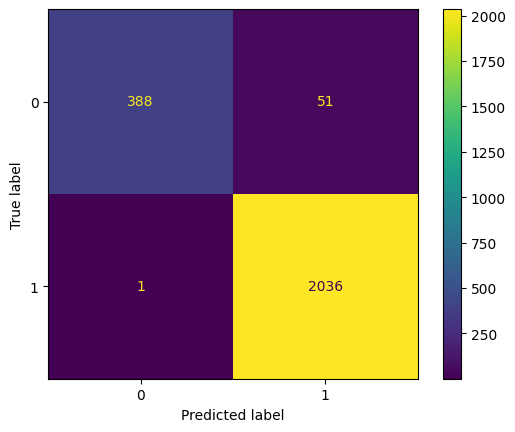

{'precision': 0.975563009103977, 'recall': 0.9995090819833088, 'accuracy': 0.9789983844911146, 'f1_score': 0.9873908826382154}


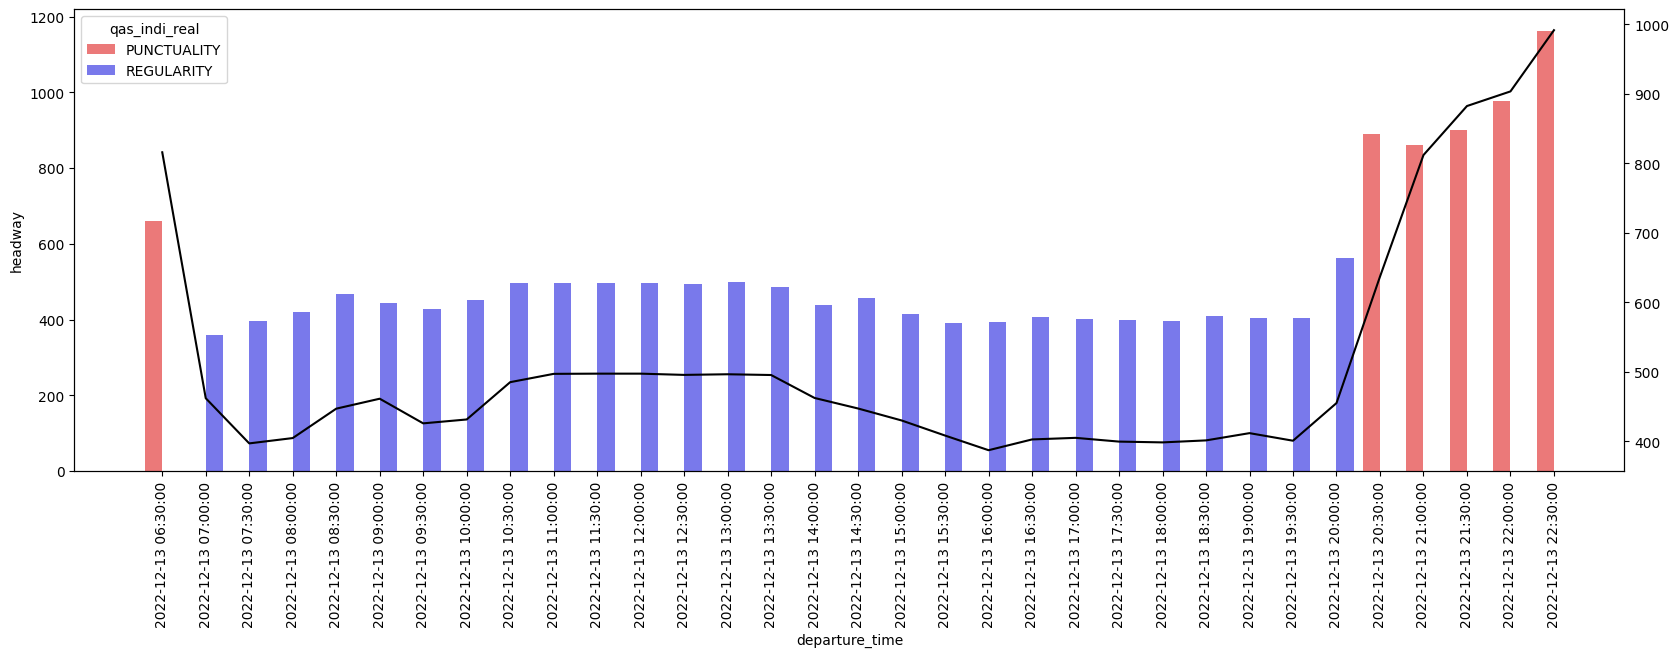

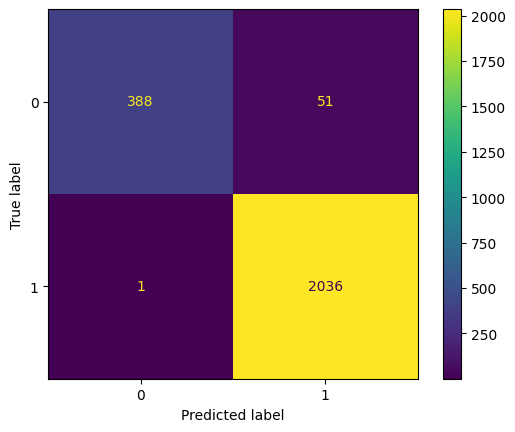

{'precision': 0.975563009103977, 'recall': 0.9995090819833088, 'accuracy': 0.9789983844911146, 'f1_score': 0.9873908826382154}


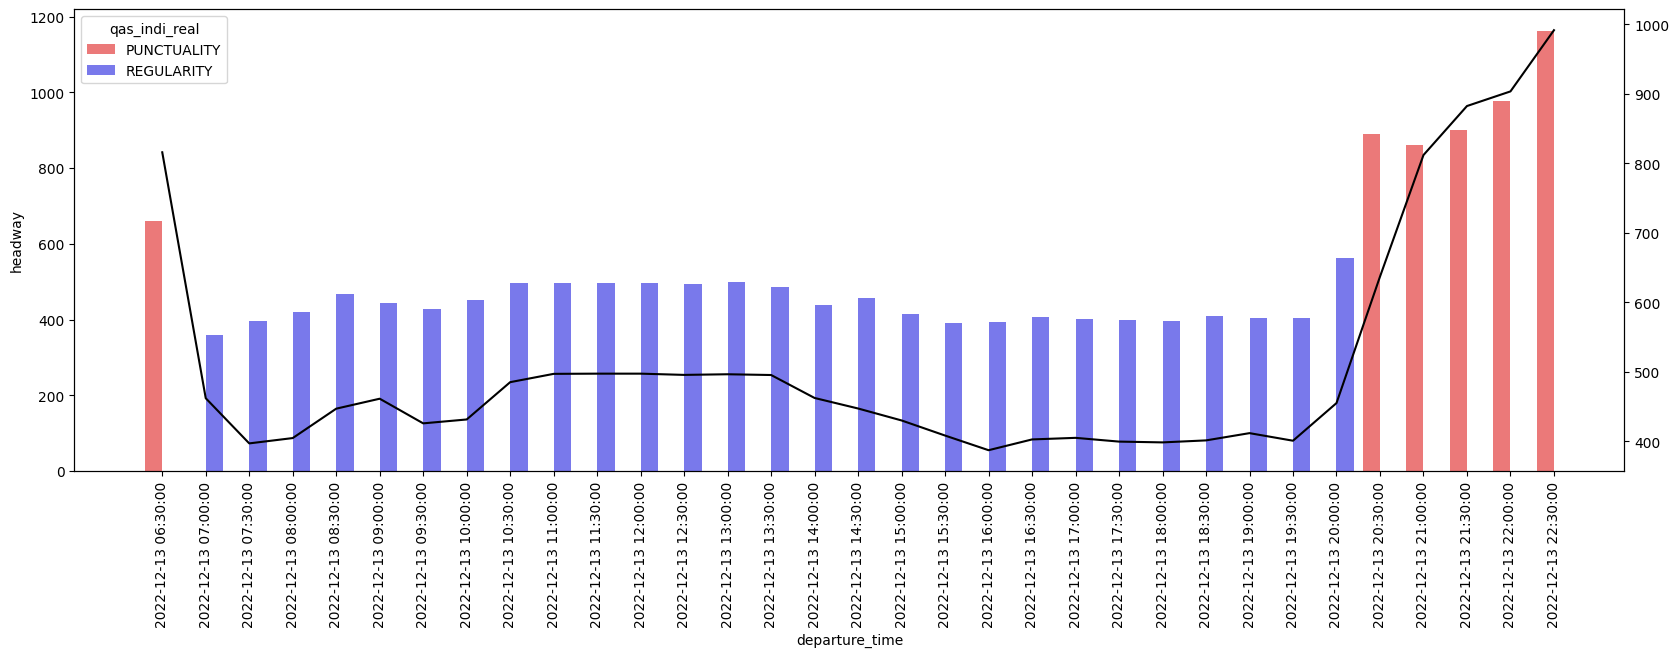

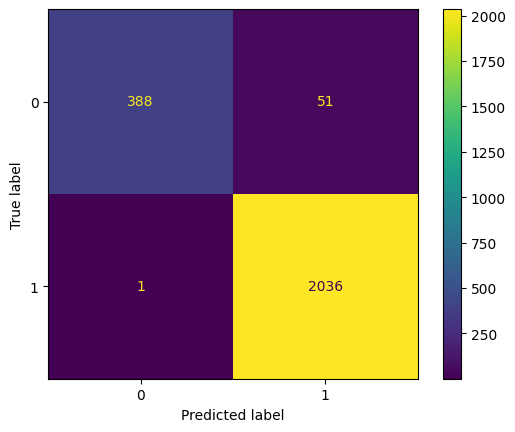

{'precision': 0.975563009103977, 'recall': 0.9995090819833088, 'accuracy': 0.9789983844911146, 'f1_score': 0.9873908826382154}


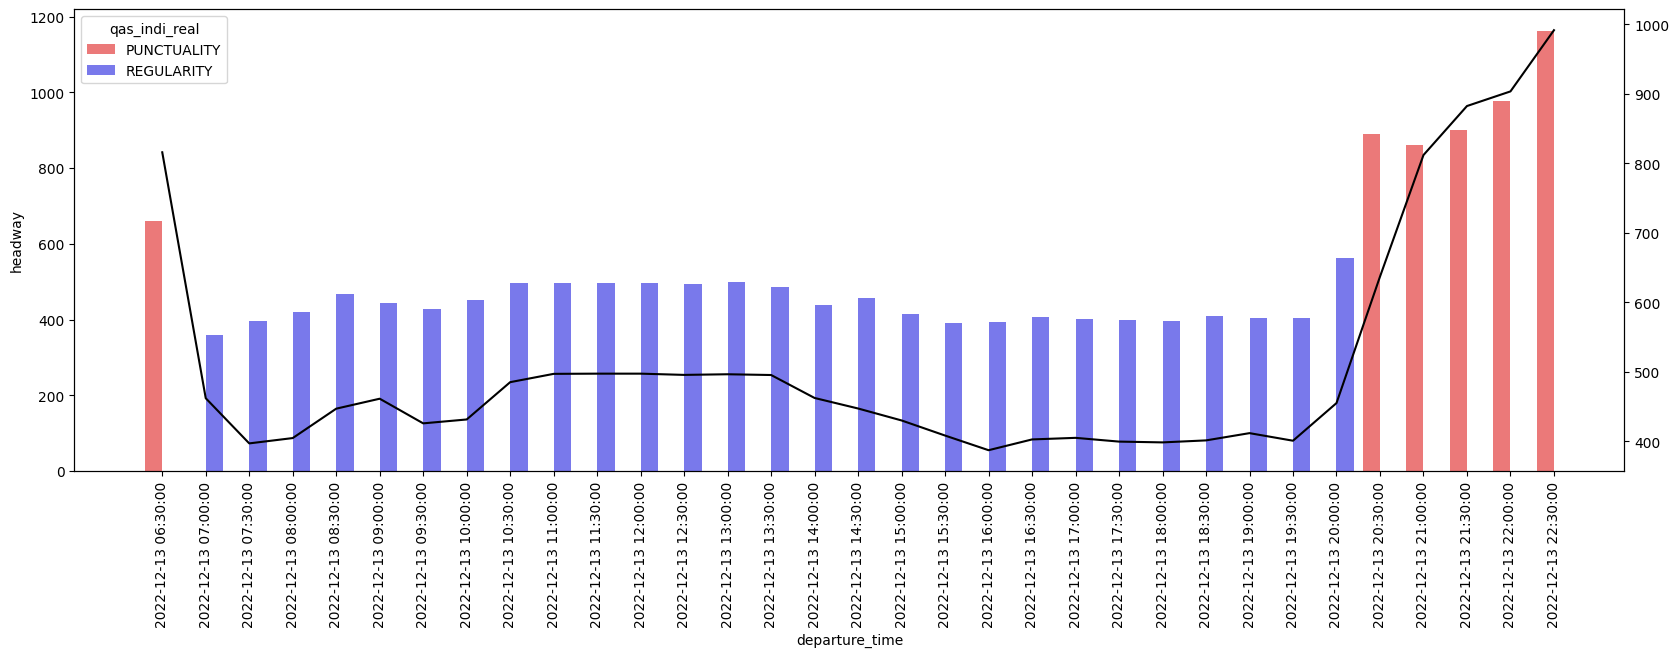

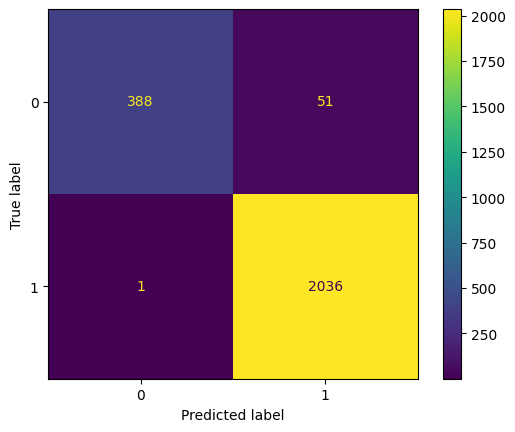

{'precision': 0.975563009103977, 'recall': 0.9995090819833088, 'accuracy': 0.9789983844911146, 'f1_score': 0.9873908826382154}


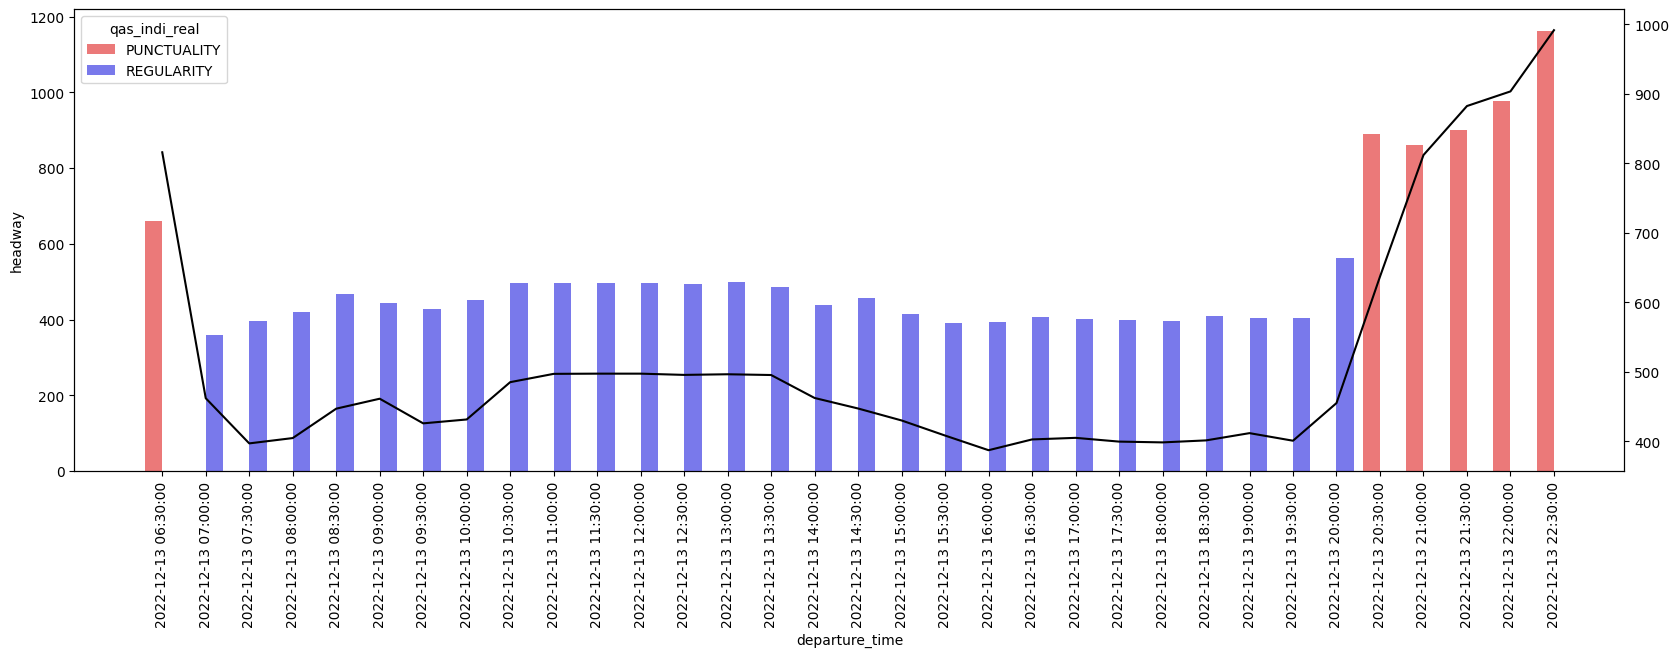

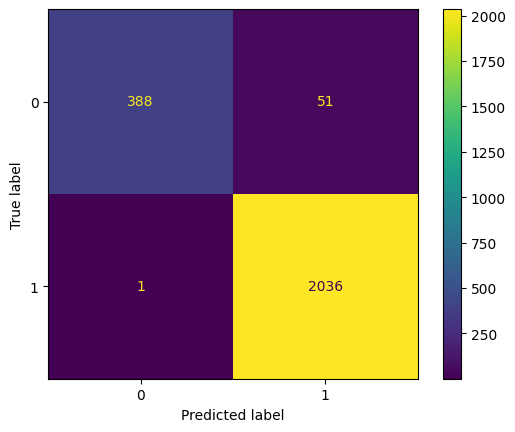

{'precision': 0.0, 'recall': 0.0, 'accuracy': 1.0, 'f1_score': 0.0}


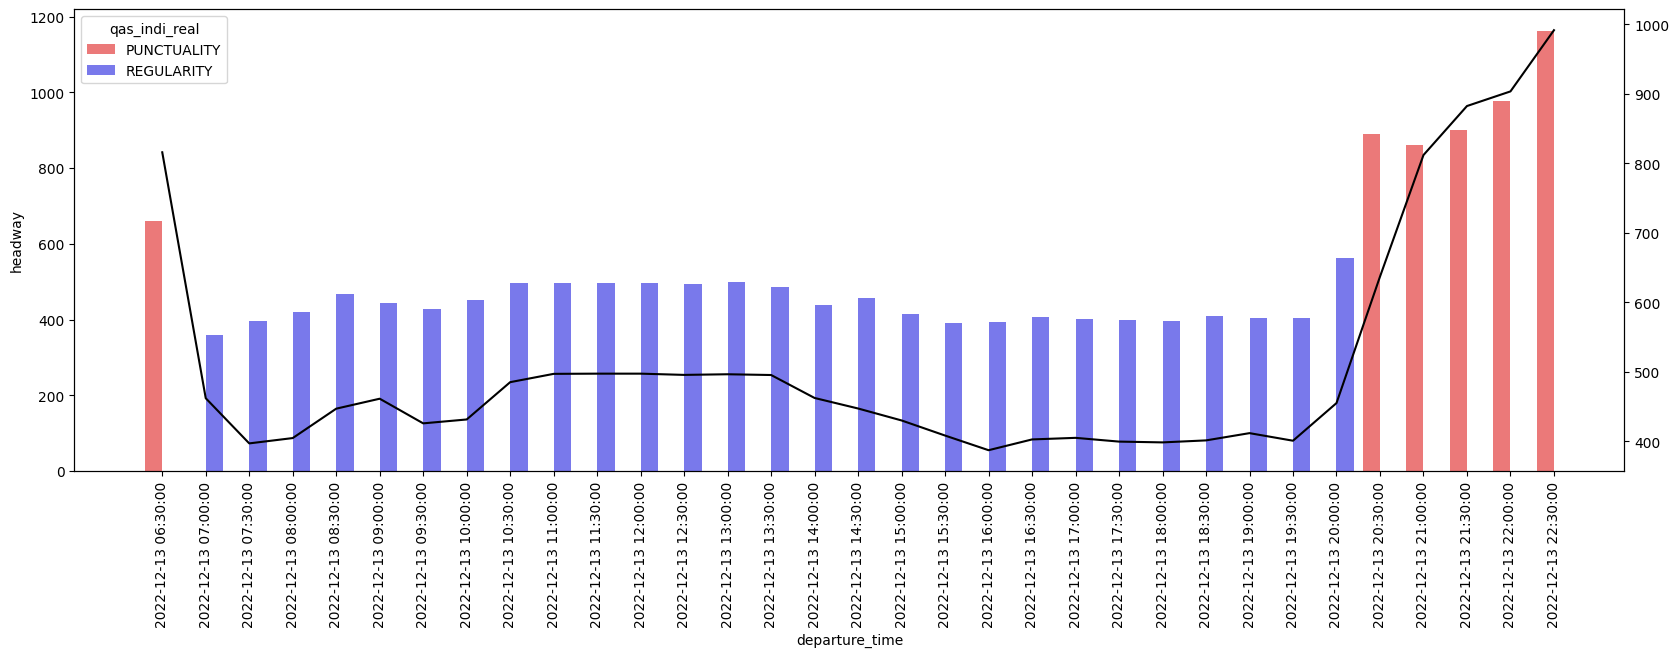

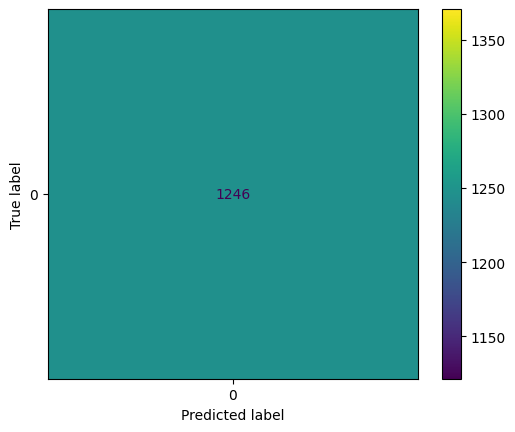

{'precision': 0.0, 'recall': 0.0, 'accuracy': 0.9740634005763689, 'f1_score': 0.0}


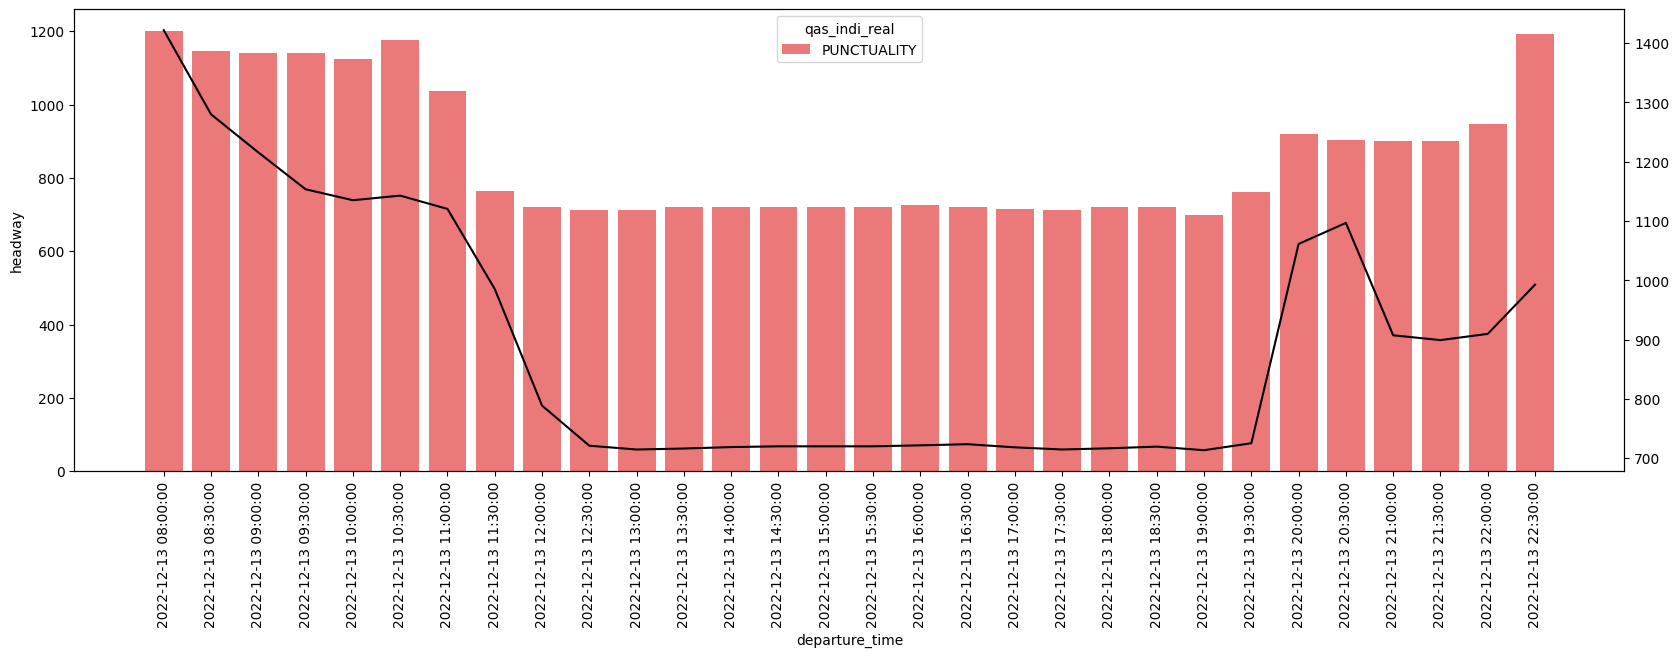

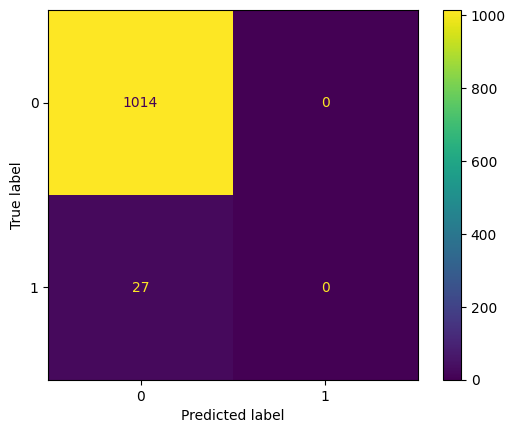

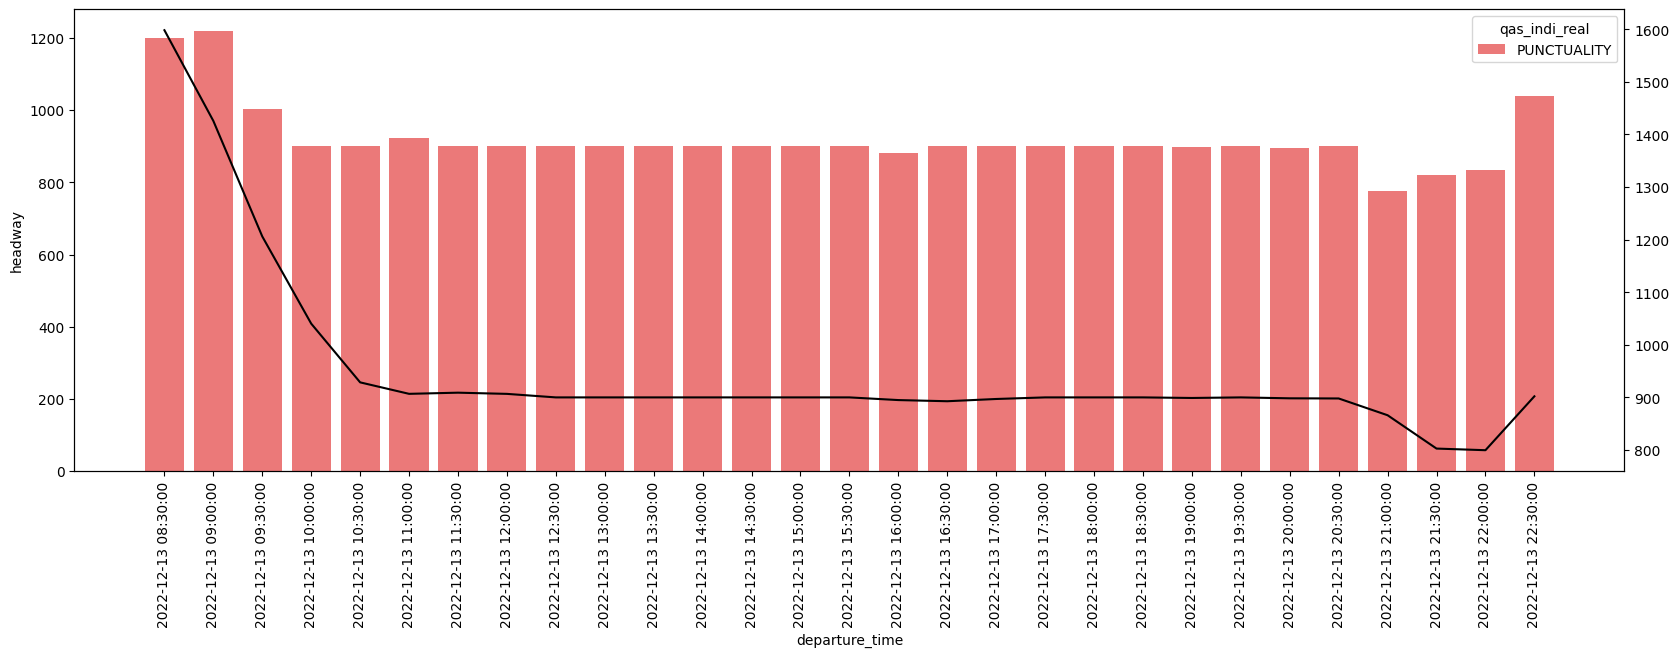

In [2]:
from hmr_utils import *
data_folder = '/Users/alfredo.leon/Desktop/DataMiningProject/Project Data-20221021/'
path = Path(data_folder+"gtfs3Sept.zip")
feed = (gk.read_feed(path, dist_units='km'))
feed.validate()
# MONDAY ROUTE 71
route_71_headways_tagged_monday_6 = retrieve_headways_from_route(feed, dates=['20210906'], route_id='34')
route_71_headways_tagged_by_timegroup_monday_6 = retrieve_average_time_periods_from_route(route_71_headways_tagged_monday_6)
print(compute_metrics_qas(route_71_headways_tagged_monday_6))
plot_confussion_matrix_predicted_qas_metric(route_71_headways_tagged_monday_6)
plot_average_timetable_for_route(route_71_headways_tagged_by_timegroup_monday_6)
# TUESDAY ROUTE 71
route_71_headways_tagged_tuesday_7 = retrieve_headways_from_route(feed, dates=['20210907'], route_id='34')
route_71_headways_tagged_by_timegroup_tuesday_7 = retrieve_average_time_periods_from_route(route_71_headways_tagged_tuesday_7)
print(compute_metrics_qas(route_71_headways_tagged_tuesday_7))
plot_confussion_matrix_predicted_qas_metric(route_71_headways_tagged_tuesday_7)
plot_average_timetable_for_route(route_71_headways_tagged_by_timegroup_tuesday_7)
# WEDNESDAY ROUTE 71
route_71_headways_tagged_wednesday_8 = retrieve_headways_from_route(feed, dates=['20210908'], route_id='34')
route_71_headways_tagged_by_timegroup_wednesday_8 = retrieve_average_time_periods_from_route(route_71_headways_tagged_wednesday_8)
print(compute_metrics_qas(route_71_headways_tagged_wednesday_8))
plot_confussion_matrix_predicted_qas_metric(route_71_headways_tagged_wednesday_8)
plot_average_timetable_for_route(route_71_headways_tagged_by_timegroup_wednesday_8)
# THURSDAY ROUTE 71
route_71_headways_tagged_thursday_9 = retrieve_headways_from_route(feed, dates=['20210909'], route_id='34')
route_71_headways_tagged_by_timegroup_thursday_9 = retrieve_average_time_periods_from_route(route_71_headways_tagged_thursday_9)
print(compute_metrics_qas(route_71_headways_tagged_thursday_9))
plot_confussion_matrix_predicted_qas_metric(route_71_headways_tagged_thursday_9)
plot_average_timetable_for_route(route_71_headways_tagged_by_timegroup_thursday_9)
# FRIDAY ROUTE 71
route_71_headways_tagged_friday_10 = retrieve_headways_from_route(feed, dates=['20210910'], route_id='34')
route_71_headways_tagged_by_timegroup_friday_10 = retrieve_average_time_periods_from_route(route_71_headways_tagged_friday_10)
print(compute_metrics_qas(route_71_headways_tagged_friday_10))
plot_confussion_matrix_predicted_qas_metric(route_71_headways_tagged_friday_10)
plot_average_timetable_for_route(route_71_headways_tagged_by_timegroup_friday_10)
# SATURDAY ROUTE 71
route_71_headways_tagged_saturday_11 = retrieve_headways_from_route(feed, dates=['20210911'], route_id='34')
route_71_headways_tagged_by_timegroup_saturday_11 = retrieve_average_time_periods_from_route(route_71_headways_tagged_saturday_11)
print(compute_metrics_qas(route_71_headways_tagged_saturday_11))
plot_confussion_matrix_predicted_qas_metric(route_71_headways_tagged_saturday_11)
plot_average_timetable_for_route(route_71_headways_tagged_by_timegroup_saturday_11)
# SUNDAY ROUTE 71
route_71_headways_tagged_sunday_12 = retrieve_headways_from_route(feed, dates=['20210912'], route_id='34')
route_71_headways_tagged_by_timegroup_sunday_12 = retrieve_average_time_periods_from_route(route_71_headways_tagged_sunday_12)
print(compute_metrics_qas(route_71_headways_tagged_sunday_12))
plot_confussion_matrix_predicted_qas_metric(route_71_headways_tagged_sunday_12)
plot_average_timetable_for_route(route_71_headways_tagged_by_timegroup_sunday_12)

In [ ]:
route_34_headways_tagged = retrieve_headways_from_route(feed, route_id='34')
route_34_headways_tagged_by_timegroup = retrieve_average_time_periods_from_route(route_34_headways_tagged)
print(compute_metrics_qas(route_34_headways_tagged))
plot_confussion_matrix_predicted_qas_metric(route_34_headways_tagged)
plot_average_timetable_for_route(route_34_headways_tagged_by_timegroup)

In [ ]:
route_55_headways_tagged = retrieve_headways_from_route(feed, route_id='55')
route_55_headways_tagged_by_timegroup = retrieve_average_time_periods_from_route(route_55_headways_tagged)
print(compute_metrics_qas(route_55_headways_tagged))
plot_confussion_matrix_predicted_qas_metric(route_55_headways_tagged)
plot_average_timetable_for_route(route_55_headways_tagged_by_timegroup)

### Now let's train a model with the tagged data to predict either PUNCTUALITY or REGULARITY

We will train a model that will first get the timegroups for the routes on the Sept 3rd data from GTFS.
The tagged real data will be based on the fact if a headway average on a timegroup (i.e from 7:30 to 8:00) is bigger than or lesser than 660 seconds (11 minutes).

In [ ]:
from hmr_utils import *
import gtfs_kit as gk
from pathlib import Path
data_folder = '/Users/alfredo.leon/Desktop/DataMiningProject/Project Data-20221021/'
path = Path(data_folder+"gtfs3Sept.zip")
feed = (gk.read_feed(path, dist_units='km'))
feed.validate()

In [ ]:
feed.calendar.head()

In [ ]:
tag_routes(feed, route_short_names=['71', '95', '34', '57'], save_folder='/Users/alfredo.leon/Desktop/DataMiningProject/tagged/')